<p align="center">
Universidade Federal de Alagoas</br>

Instituto de Computação</br>

</p>

#Trabalho Prático AB2

Disciplina: Sistemas Distribuídos

Semestre letivo: 2017.1

Professor: André Lage Freitas

## Especificação

**Importante**. Leia atentamente essa seção pois só serão aceitos trabalhos que obedecerem as a especificações a seguir. 

Baseado(a) no exemplo a seguir de implementação do B-multicast em Julia, façam os exercícios descritos nesse documento.

# -----------------------------------------------------------------------------------------------------------
# R_multicast
### Definition: Reliability only guarantees that if at least one process has received the message: every other process (of the group) will receive as well. The sender can be a point of failure, but the processes can't; all processes are supposed to be correct.
### Implementation: It is implemented using a B_multicast underneath (which uses a reliable unicast underneath). Sender does a B_multicast and whenever a process receives the message: it will check wheter or not it didn't received it before. If it didn't: marks as received and does a B_multicast. If it did: nothing happens.
### Complexity: In the worst case: all processes succesfully receives the message from the sender, and then each process sends the message to every one again. Summing n² messages being sent.
### Proof: Suppose there are two correct processes i and j, and that I received the message while j didn't. But since I did receive the message, it would have run the B_multicast and sent the message to j. So, by contradiction: we've proven R_multicast's reliability.

In [1]:
 @everywhere function B_async_deliver(group, from, message)
    global received
#     println(message)
#     flush(stdout)
#     sleep(0.01)
    
    if !(from in received)
        push!(received, from)
        if (from != myid())
            B_async_multicast(group, message, B_async_deliver)
        end
        sleep(0.01)
    end
end

@everywhere function B_async_multicast(group, message, B_deliver)
    my_id = myid()
    @sync for i in group
        @spawnat i B_async_deliver(my_id, message)
    end
end

function R_async_multicast(group, message)
    @everywhere group global received = Set()

    @sync for i in group
        @spawnat i B_sync_multicast(group, message, B_sync_deliver)
    end
end

LoadError: UndefVarError: @everywhere not defined

In [2]:
syncTimes = []
for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(syncTimes, @elapsed R_sync_multicast(group, "Sync hi  -- $i"))
    if i == 1
        println(counter)
    end
end

UndefVarError: UndefVarError: iterations not defined

In [3]:
asyncTimes = []
asyncTotalTime = for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(asyncTimes, @elapsed R_async_multicast(group, "Async hi -- $i"))
end

UndefVarError: UndefVarError: iterations not defined

In [4]:
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

# plot(1:length(syncTimes),
#          [syncTimes, asyncTimes],
#          title="Sync x Async B_multicast",
#          label=["Sync", "Async"],
#          xlabel="Runs",
#          ylabel="Time (s)")
groupedbar(
           ["R_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncStdTime asyncStdTime],
           label = ["Sync", "Async"],
           xlabel = "Runs",
           ylabel = "Time (seconds)",
           title = "Sync x Async R_multicast",
           framestyle = :box)

BoundsError: BoundsError: attempt to access 0-element Array{Float64,1} at index [-10]

In [5]:
# function B_multicast(g,m,B_deliver)
#    for p in g
#        remotecall(p, B_deliver, m)
#    end
# end

# Adding 3 processes (workers)
#addprocs(3)

# My group is composed by all workers
# g = workers()

# Multicasting "oi!" message to group `g` by assuming `println` as B_deliver function.
# B_multicast(g,"oi!",println)

### Preparations

In [6]:
using Distributed
using Plots
using StatsPlots

function mean(array)
    return(sum(array) / length(array))
end

function std(array)
    s, m = 0, mean(array)
    for x in array
        s += (x - m)*(x - m)
    end
    return(sqrt(s / (length(array) - 1)))
end

z, iterations = 1.96, 50
rmprocs(workers())
addprocs(10)
group = workers()

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\Distributed\src\cluster.jl:928


10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

### Exercício 1: Sincronismo (2,0 pontos)

Adicione 10 processos com o comando `addprocs` abaixo. 

Modifique a implementação do B-multicast para utilizar communicação síncrona.

In [7]:
@everywhere function B_deliver(message)
    println(message)
    sleep(0.01)
end

function B_sync_multicast(group, message, B_deliver)
    for i in group
        @sync @spawnat i B_deliver(message)
    end
end

function B_async_multicast(group, message, B_deliver)
    @sync for i in group
        @spawnat i B_deliver(message)
    end
end

B_async_multicast (generic function with 1 method)

Execute as duas versões do B-multicast (síncrona e assíncrona) e compare as saídas.

In [8]:
B_sync_multicast(group, "B_sync_multicast: Hello ^~^", B_deliver)
B_async_multicast(group, "B_async_multicast: Hello ^~^", B_deliver)

      From worker 2:	B_sync_multicast: Hello ^~^
      From worker 3:	B_sync_multicast: Hello ^~^
      From worker 4:	B_sync_multicast: Hello ^~^
      From worker 5:	B_sync_multicast: Hello ^~^
      From worker 6:	B_sync_multicast: Hello ^~^
      From worker 7:	B_sync_multicast: Hello ^~^
      From worker 8:	B_sync_multicast: Hello ^~^
      From worker 9:	B_sync_multicast: Hello ^~^
      From worker 10:	B_sync_multicast: Hello ^~^
      From worker 11:	B_sync_multicast: Hello ^~^
      From worker 4:	B_async_multicast: Hello ^~^
      From worker 3:	B_async_multicast: Hello ^~^
      From worker 5:	B_async_multicast: Hello ^~^
      From worker 6:	B_async_multicast: Hello ^~^
      From worker 7:	B_async_multicast: Hello ^~^
      From worker 8:	B_async_multicast: Hello ^~^
      From worker 10:	B_async_multicast: Hello ^~^
      From worker 11:	B_async_multicast: Hello ^~^
      From worker 9:	B_async_multicast: Hello ^~^
      From worker 2:	B_async_multicast: Hello ^~^


A ordem das mensagens das saídas foram as mesmas para ambas versões do B-multicast? Por quê?

**Resposta**: _Pois a versão assíncrona permite que o B_deliver de cada indivíduo do grupo seja executado em paralelo, e assim: não tem garantias de que a ordem que cada um vai terminar (e imprimir na tela) é a mesma sempre_


### Exercício 2: Análise de desempenho do B-multicast (2,0 pontos)

Meça o tempo de execução duas versões do B-multicast (síncrona e assíncrona). Dica: utilize a macro `@time`.
* Execute 50 vezes essa medição e construa um gráfico em forma de barras:
	* cada barra representando cada versão do B-multicast;
	* calcule e coloque no gráfico o [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) com nível de 95%.


In [9]:
syncTimes = []
for i in 1:iterations
    println("$i ------------------------------------------")
    push!(syncTimes, @elapsed B_sync_multicast(group, "Sync  hi -- $i iteration", B_deliver))
end

asyncTimes = []
for i in 1:iterations
    println("$i ------------------------------------------")
    push!(asyncTimes, @elapsed B_async_multicast(group, "Async hi -- $i iteration", B_deliver))
end

syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)
syncConfTime, asyncConfTime = z*syncStdTime/sqrt(length(syncTimes)), z*asyncStdTime/sqrt(length(asyncTimes))

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

1 ------------------------------------------
      From worker 2:	Sync  hi -- 1 iteration
      From worker 3:	Sync  hi -- 1 iteration
      From worker 4:	Sync  hi -- 1 iteration
      From worker 5:	Sync  hi -- 1 iteration
      From worker 6:	Sync  hi -- 1 iteration
      From worker 7:	Sync  hi -- 1 iteration
      From worker 8:	Sync  hi -- 1 iteration
      From worker 9:	Sync  hi -- 1 iteration
      From worker 10:	Sync  hi -- 1 iteration
      From worker 11:	Sync  hi -- 1 iteration
2 ------------------------------------------
      From worker 2:	Sync  hi -- 2 iteration
      From worker 3:	Sync  hi -- 2 iteration
      From worker 4:	Sync  hi -- 2 iteration
      From worker 5:	Sync  hi -- 2 iteration
      From worker 6:	Sync  hi -- 2 iteration
      From worker 7:	Sync  hi -- 2 iteration
      From worker 8:	Sync  hi -- 2 iteration
      From worker 9:	Sync  hi -- 2 iteration
      From worker 10:	Sync  hi -- 2 iteration
      From worker 11:	Sync  hi -- 2 iteration
3 ----

      From worker 10:	Sync  hi -- 17 iteration
      From worker 11:	Sync  hi -- 17 iteration
18 ------------------------------------------
      From worker 2:	Sync  hi -- 18 iteration
      From worker 3:	Sync  hi -- 18 iteration
      From worker 4:	Sync  hi -- 18 iteration
      From worker 5:	Sync  hi -- 18 iteration
      From worker 6:	Sync  hi -- 18 iteration
      From worker 7:	Sync  hi -- 18 iteration
      From worker 8:	Sync  hi -- 18 iteration
      From worker 9:	Sync  hi -- 18 iteration
      From worker 10:	Sync  hi -- 18 iteration
      From worker 11:	Sync  hi -- 18 iteration
19 ------------------------------------------
      From worker 2:	Sync  hi -- 19 iteration
      From worker 3:	Sync  hi -- 19 iteration
      From worker 4:	Sync  hi -- 19 iteration
      From worker 5:	Sync  hi -- 19 iteration
      From worker 6:	Sync  hi -- 19 iteration
      From worker 7:	Sync  hi -- 19 iteration
      From worker 8:	Sync  hi -- 19 iteration
      From worker 9:	Sync  hi 

      From worker 10:	Sync  hi -- 34 iteration
      From worker 11:	Sync  hi -- 34 iteration
35 ------------------------------------------
      From worker 2:	Sync  hi -- 35 iteration
      From worker 3:	Sync  hi -- 35 iteration
      From worker 4:	Sync  hi -- 35 iteration
      From worker 5:	Sync  hi -- 35 iteration
      From worker 6:	Sync  hi -- 35 iteration
      From worker 7:	Sync  hi -- 35 iteration
      From worker 8:	Sync  hi -- 35 iteration
      From worker 9:	Sync  hi -- 35 iteration
      From worker 10:	Sync  hi -- 35 iteration
      From worker 11:	Sync  hi -- 35 iteration
36 ------------------------------------------
      From worker 2:	Sync  hi -- 36 iteration
      From worker 3:	Sync  hi -- 36 iteration
      From worker 4:	Sync  hi -- 36 iteration
      From worker 5:	Sync  hi -- 36 iteration
      From worker 6:	Sync  hi -- 36 iteration
      From worker 7:	Sync  hi -- 36 iteration
      From worker 8:	Sync  hi -- 36 iteration
      From worker 9:	Sync  hi 

1 ------------------------------------------
      From worker 2:	Async hi -- 1 iteration
      From worker 6:	Async hi -- 1 iteration
      From worker 9:	Async hi -- 1 iteration
      From worker 7:	Async hi -- 1 iteration
      From worker 3:	Async hi -- 1 iteration
      From worker 4:	Async hi -- 1 iteration
      From worker 5:	Async hi -- 1 iteration
      From worker 8:	Async hi -- 1 iteration
      From worker 10:	Async hi -- 1 iteration
      From worker 11:	Async hi -- 1 iteration
2 ------------------------------------------
      From worker 2:	Async hi -- 2 iteration
      From worker 6:	Async hi -- 2 iteration
      From worker 9:	Async hi -- 2 iteration
      From worker 3:	Async hi -- 2 iteration
      From worker 4:	Async hi -- 2 iteration
      From worker 5:	Async hi -- 2 iteration
      From worker 7:	Async hi -- 2 iteration
      From worker 8:	Async hi -- 2 iteration
      From worker 10:	Async hi -- 2 iteration
      From worker 11:	Async hi -- 2 iteration
3 ----

24 ------------------------------------------
      From worker 2:	Async hi -- 24 iteration
      From worker 6:	Async hi -- 24 iteration
      From worker 8:	Async hi -- 24 iteration
      From worker 11:	Async hi -- 24 iteration
      From worker 3:	Async hi -- 24 iteration
      From worker 4:	Async hi -- 24 iteration
      From worker 5:	Async hi -- 24 iteration
      From worker 7:	Async hi -- 24 iteration
      From worker 9:	Async hi -- 24 iteration
      From worker 10:	Async hi -- 24 iteration
25 ------------------------------------------
      From worker 2:	Async hi -- 25 iteration
      From worker 7:	Async hi -- 25 iteration
      From worker 9:	Async hi -- 25 iteration
      From worker 3:	Async hi -- 25 iteration
      From worker 4:	Async hi -- 25 iteration
      From worker 5:	Async hi -- 25 iteration
      From worker 6:	Async hi -- 25 iteration
      From worker 8:	Async hi -- 25 iteration
      From worker 10:	Async hi -- 25 iteration
      From worker 11:	Async hi 

46 ------------------------------------------
      From worker 2:	Async hi -- 46 iteration
      From worker 6:	Async hi -- 46 iteration
      From worker 9:	Async hi -- 46 iteration
      From worker 3:	Async hi -- 46 iteration
      From worker 4:	Async hi -- 46 iteration
      From worker 5:	Async hi -- 46 iteration
      From worker 7:	Async hi -- 46 iteration
      From worker 8:	Async hi -- 46 iteration
      From worker 10:	Async hi -- 46 iteration
      From worker 11:	Async hi -- 46 iteration
47 ------------------------------------------
      From worker 2:	Async hi -- 47 iteration
      From worker 7:	Async hi -- 47 iteration
      From worker 10:	Async hi -- 47 iteration
      From worker 3:	Async hi -- 47 iteration
      From worker 4:	Async hi -- 47 iteration
      From worker 5:	Async hi -- 47 iteration
      From worker 6:	Async hi -- 47 iteration
      From worker 8:	Async hi -- 47 iteration
      From worker 9:	Async hi -- 47 iteration
      From worker 11:	Async hi 

**Gráfico**:  

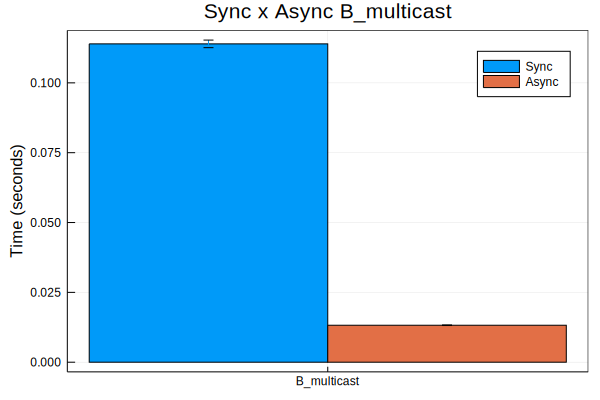

In [10]:
groupedbar(["B_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncConfTime asyncConfTime],
           label = ["Sync", "Async"],
           ylabel = "Time (seconds)",
           title = "Sync x Async B_multicast",
           framestyle = :box)

* Qual das duas versões teve o menor tempo de execução? Por quê?

**Resposta**: _A versão assíncrona. Porque na versão assíncrona, cada mensagem é enviada e recebida em paralelo; enquanto a versão síncrona é sequencial: fazendo assim com que a versão assíncrona seja até n vezes mais rápido que a versão síncrona_



### Exercício 3: Análise de desempenho do R-multicast (3,0 pontos)

Implemente duas versões do algoritmo R-multicast: uma assíncrona e outra síncrona.

### Preparations

In [11]:
@everywhere group global received = Set()

* R-multicast assíncrono

In [12]:
@everywhere function R_sync_deliver(group, from, message)
#     global received

    if !(message in received)
        push!(received, message)
        if from != myid()
            B_sync_multicast(group, message)
        end
        println(message)
        sleep(0.01)
    end
end

@everywhere function B_sync_multicast(group, message)
    my_id = myid()
    for i in group
        @sync @spawnat i R_sync_deliver(group, my_id, message)
    end
end

function R_sync_multicast(group, message)
    B_sync_multicast(group, message)
end

R_sync_multicast (generic function with 1 method)

* R-multicast assíncrono

In [13]:
@everywhere function R_async_deliver(group, from, message)
#     global received

    if !(message in received)
        push!(received, message)
        if from != myid()
            B_async_multicast(group, message)
        end
        println(message)
        sleep(0.01)
    end
end

@everywhere function B_async_multicast(group, message)
    my_id = myid()
    @sync for i in group
        @spawnat i R_async_deliver(group, my_id, message)
    end
end

function R_async_multicast(group, message)
    B_async_multicast(group, message)
end

R_async_multicast (generic function with 1 method)

Faça a mesma análise de desempenho para o R-multicast que você fez no Exercício 2.

In [ ]:
syncTimes = []
for i in 1:iterations
    println("$i ------------------------------------------")
    push!(syncTimes, @elapsed R_sync_multicast(group, "Sync  hi -- $i iteration"))
end

asyncTimes = []
for i in 1:iterations
    println("$i ------------------------------------------")
    push!(asyncTimes, @elapsed R_async_multicast(group, "Async hi -- $i iteration"))
end

syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)
syncConfTime, asyncConfTime = z*syncStdTime/sqrt(length(syncTimes)), z*asyncStdTime/sqrt(length(asyncTimes))

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

1 ------------------------------------------
      From worker 11:	Sync  hi -- 1 iteration
      From worker 10:	Sync  hi -- 1 iteration
      From worker 9:	Sync  hi -- 1 iteration
      From worker 8:	Sync  hi -- 1 iteration
      From worker 7:	Sync  hi -- 1 iteration
      From worker 6:	Sync  hi -- 1 iteration
      From worker 5:	Sync  hi -- 1 iteration
      From worker 4:	Sync  hi -- 1 iteration
      From worker 3:	Sync  hi -- 1 iteration
      From worker 2:	Sync  hi -- 1 iteration
2 ------------------------------------------
      From worker 11:	Sync  hi -- 2 iteration
      From worker 10:	Sync  hi -- 2 iteration
      From worker 9:	Sync  hi -- 2 iteration
      From worker 8:	Sync  hi -- 2 iteration
      From worker 7:	Sync  hi -- 2 iteration
      From worker 6:	Sync  hi -- 2 iteration
      From worker 5:	Sync  hi -- 2 iteration
      From worker 4:	Sync  hi -- 2 iteration
      From worker 3:	Sync  hi -- 2 iteration
      From worker 2:	Sync  hi -- 2 iteration
3 ----

18 ------------------------------------------
      From worker 11:	Sync  hi -- 18 iteration
      From worker 10:	Sync  hi -- 18 iteration
      From worker 9:	Sync  hi -- 18 iteration
      From worker 8:	Sync  hi -- 18 iteration
      From worker 7:	Sync  hi -- 18 iteration
      From worker 6:	Sync  hi -- 18 iteration
      From worker 5:	Sync  hi -- 18 iteration
      From worker 4:	Sync  hi -- 18 iteration
      From worker 3:	Sync  hi -- 18 iteration
      From worker 2:	Sync  hi -- 18 iteration
19 ------------------------------------------
      From worker 11:	Sync  hi -- 19 iteration
      From worker 10:	Sync  hi -- 19 iteration
      From worker 9:	Sync  hi -- 19 iteration
      From worker 8:	Sync  hi -- 19 iteration
      From worker 7:	Sync  hi -- 19 iteration
      From worker 6:	Sync  hi -- 19 iteration
      From worker 5:	Sync  hi -- 19 iteration
      From worker 4:	Sync  hi -- 19 iteration
      From worker 3:	Sync  hi -- 19 iteration
      From worker 2:	Sync  hi 

**Gráfico**:

In [ ]:
groupedbar(["R_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncConfTime asyncConfTime],
           label = ["Sync", "Async"],
           ylabel = "Time (seconds)",
           title = "Sync x Async R_multicast",
           framestyle = :box)

* Qual das duas versões (R-multicast síncrono e assíncrono) teve o menor tempo de execução? Por quê?

**Resposta**: _Novamente, a versão assíncrona tem vantagem de tempo sobre a síncrona. E o motivo é o mesmo, a única diferença é que agora existe mais trabalho a ser feito, visto que para garantir a confiabilidade: o R_multicast precisa mandar mais mensagens; aumentando assim a diferença entre os dois, como pode ser observada no gráfico acima._



### Exercício 4: Análise de desempenho: B-multicast vs. R-multicast (3,0 pontos)

Para cada uma das comparações abaixo, qual dos algoritmos teve o menor tempo de execução? Por quê?

* B-multicast assíncrono vs. R-multicast assíncrono.
    

**Resposta**: B_multicast assíncrono teve um menor tempo de execução. Pois este algoritmo não precisa guarantir que se um processo recebeu a mensagem: todos vão receber. Por esse motivo: o B_multicast manda menos mensagems e teve um tempo de execução menor.
    
* B-multicast síncrono vs. R-multicast síncrono.


**Resposta**: Da mesma forma que o B_multicast assíncrono é mais rápido que o R_multicast assícrono; o B_multicast síncrono também é mais rápido, e pelos mesmos motivos.

## Entrega

As respostas deverão ser entregues nos devidos campos desse arquivo, ou seja, em [Markdown](https://en.wikipedia.org/wiki/Markdown) e no formato [IJulia Notebook](https://github.com/JuliaLang/IJulia.jl).

O programa deve ser implementado na linguagem de programação **Julia**. Seu trabalho será testado na [JuliaBox](https://juliabox.com), portanto teste seu arquivo IJulia na JulizBox antes de enviá-lo.


### Forma 

O arquivo IJulia Notebook deverá ser entregue ao Professor **exclusivamente através do Google Classroom**.



A responsabilidade sobre a integridade do arquivo contendo trabalho é exclusivamente dos discentes. Serão ignorados os trabalhos cujos arquivos não conseguirem ser abertos pelo Professor.

### Prazos

O prazo de entrega sem atraso é o dia **18/11/17**.

Trabalhos entregues com atraso serão aceitos, no máximo, até o o dia **19/11/17**. Serão descontados 5% da nota obtida por dia de atraso.


## Pontuação extra

O(a) discente que realizar mais tarefas, além do que foi especificado neste trabalho, o professor atribuirá de 0,5 a 1,0 ponto extra a depender da relevância da contribuição no programa. O critério será decidido pelo professor. 

O(a) discente deve indicar qual é a tarefa executada. Por exemplo, adição de funcionalidades, armazenamento de dados em arquivo, documentação de código, comentários em inglês sem erros ortográficos, etc.


**Plágio** A nota zero será atribuída caso haja qualquer tipo de cópia parcial ou integral assim como as devidas medidas legais. Leia a [cartilha sobre plágio](http://www.noticias.uff.br/arquivos/cartilha-sobre-plagio-academico.pdf).

## Disclaimer

Esse material foi elaborado pelo [Prof. André Lage Freitas](https://sites.google.com/a/ic.ufal.br/andrelage/) e está licenciado sob a licença _GNU General Public License v3.0_.